In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.lines as lines
import numpy as np
from six.moves import cPickle as pickle
import json
from tqdm import tqdm

#### dataフォルダへのパス

In [5]:
dir_path = 'SGGdata/'

In [6]:
topk_dets_file = os.path.join(dir_path, 'rel_detections_topk.pkl')
with open(topk_dets_file, 'rb') as f:
    topk_dets = pickle.load(f)

FileNotFoundError: ignored

In [ ]:
topk_dets

In [ ]:
print(len(topk_dets))
print(topk_dets[0].keys())
print(topk_dets[0]['det_boxes_o_top'].shape)
print(topk_dets[0]['det_scores_top'].shape)
min_len = 100
for det in topk_dets:
    if min_len > det['det_scores_top'].shape[0]:
        min_len = det['det_scores_top'].shape[0]
print(min_len)

In [ ]:
img_path = 'data/images/'
with open('data/objects.json') as f:
    obj_cats = json.load(f)
with open('data/predicates.json') as f:
    prd_cats = json.load(f)

In [ ]:
def box_overlap(box1, box2):
    overlap = 0.0
    box_area = (
        (box2[2] - box2[0] + 1) *
        (box2[3] - box2[1] + 1)
    )
    iw = (
        min(box1[2], box2[2]) -
        max(box1[0], box2[0]) + 1
    )
    if iw > 0:
        ih = (
            min(box1[3], box2[3]) -
            max(box1[1], box2[1]) + 1
        )
        if ih > 0:
            ua = float(
                (box1[2] - box1[0] + 1) *
                (box1[3] - box1[1] + 1) +
                box_area - iw * ih
            )
            overlap = iw * ih / ua
    return overlap

# box1 and box2 are in [x1, y1. w. h] format
def box_union(box1, box2):
    xmin = min(box1[0], box2[0])
    ymin = min(box1[1], box2[1])
    xmax = max(box1[0] + box1[2] - 1, box2[0] + box2[2] - 1)
    ymax = max(box1[1] + box1[3] - 1, box2[1] + box2[3] - 1)
    return [xmin, ymin, xmax - xmin + 1, ymax - ymin + 1]

def box2rect(img, box):
    x = box[0] + edge_width / 2
    y = box[1] + edge_width / 2
    w = box[2] - box[0] - edge_width
    h = box[3] - box[1] - edge_width
    return x, y, w, h

ind:  22072
image:  2343721.jpg
topk:  10


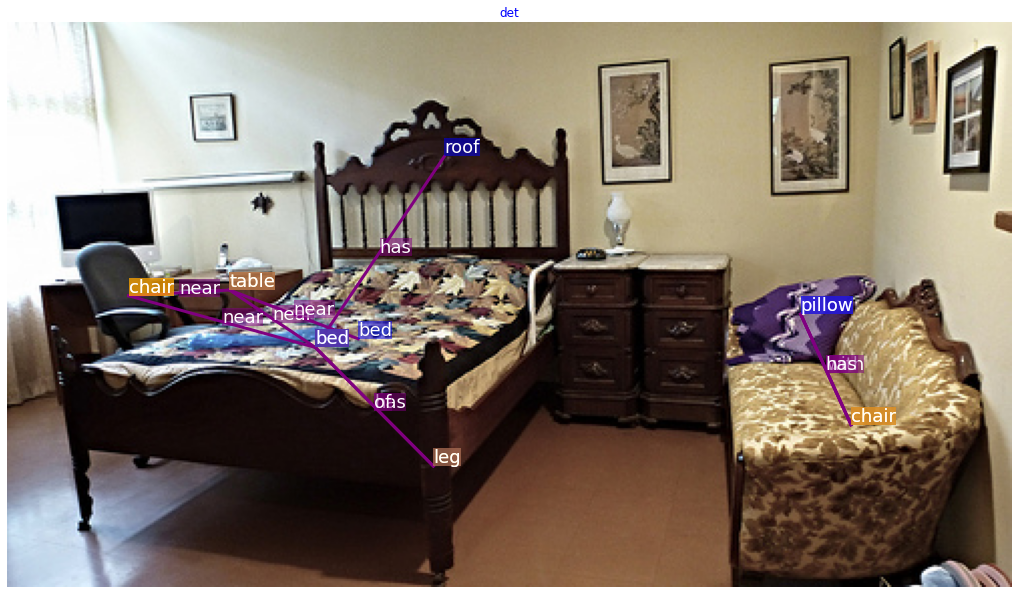

0: pillow on chair
		total score:	 0.566049
1: table near bed
		total score:	 0.461307
2: bed has leg
		total score:	 0.387796
3: chair with pillow
		total score:	 0.354023
4: chair near bed
		total score:	 0.301875
5: bed has roof
		total score:	 0.267769
6: chair near table
		total score:	 0.243498
7: chair has pillow
		total score:	 0.218835
8: table near bed
		total score:	 0.218583
9: leg of bed
		total score:	 0.215819


In [ ]:
edge_width = 3
font_size = 18
topk = 10  # 100
score_thr = 0.1

save_output = False

#以下のindのコメントアウトをはずして実行
#ind = 17867
#ind = 20769
#ind = 1852
#ind = 10217
#ind = 2087
#ind = 25814
ind = 22072
#ind = 8630
#ind = 14208
print('ind: ', ind)

det = topk_dets[ind]

sbj_boxes = det['det_boxes_s_top']
sbj_labels = det['det_labels_s_top']
obj_boxes = det['det_boxes_o_top']
obj_labels = det['det_labels_o_top']
prd_labels = det['det_labels_p_top']
det_scores = det['det_scores_top']

img_name = det['image'].split('/')[-1]
print('image: ', img_name)
print('topk: ', topk)
#print('sbj_labels.shape[0]: ', sbj_labels.shape[0])

img = mpimg.imread(img_path + img_name)

fig = plt.figure(figsize=(18, 12))
ax = plt.gca()
plt.imshow(img)
plt.axis('off')
det_title = plt.title('det')
plt.setp(det_title, color='b')
for j in range(min(topk, sbj_labels.shape[0])):
    # det
    det_score = det_scores[j]
    if det_score < score_thr:
        continue
    sbj_label = sbj_labels[j]
    obj_label = obj_labels[j]
    prd_label = prd_labels[j]
    sbj_box = sbj_boxes[j]
    obj_box = obj_boxes[j]
    s_name = obj_cats[sbj_label]
    o_name = obj_cats[obj_label]
    p_name = prd_cats[prd_label]
    
    s_x, s_y, s_w, s_h = box2rect(img, sbj_box)
    s_cx = s_x + s_w // 2
    s_cy = s_y + s_h // 2
    ax.text(s_cx, s_cy - 2,
            s_name,
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='orange', alpha=0.5, pad=0, edgecolor='none'))
    
    o_x, o_y, o_w, o_h = box2rect(img, obj_box)
    o_cx = o_x + o_w // 2
    o_cy = o_y + o_h // 2
    ax.text(o_cx, o_cy - 2,
            o_name,
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='blue', alpha=0.5, pad=0, edgecolor='none'))
    
    rel_l = lines.Line2D([s_cx, o_cx], [s_cy, o_cy], color='purple', linewidth=edge_width)
    ax.add_line(rel_l)
    ax.text((s_cx + o_cx) / 2, (s_cy + o_cy) / 2,
            p_name,
            fontsize=font_size,
            color='white',
            bbox=dict(facecolor='purple', alpha=0.5, pad=0, edgecolor='none'))

plt.show()
plt.close(fig)

# print names and scores
for j in range(min(topk, sbj_labels.shape[0])):
    # det
    det_score = det_scores[j]
    if det_score < score_thr:
        continue
    sbj_label = sbj_labels[j]
    obj_label = obj_labels[j]
    prd_label = prd_labels[j]
    s_name = obj_cats[sbj_label]
    o_name = obj_cats[obj_label]
    p_name = prd_cats[prd_label]
    print('{}: {} {} {}'.format(j, s_name, p_name, o_name))
    print('\t\ttotal score:\t {:.6f}'.format(det_score))